In [1]:
import torch
import torch.nn as nn
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from torch.autograd.function import Function
import numpy as np
import torch.utils.data as Data
import math
from torch.utils.data import DataLoader
import torch.optim as optim
import copy
import time
from torch.optim import Adam
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from torch.cuda.amp import autocast as autocast
from torch.cuda.amp import GradScaler
import matplotlib.pyplot as plt

from torch import randperm
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import train_test_split


# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

import argparse

In [2]:
# train_x_list = "C:/Users/Savior/Desktop/wisdm/HAR-datasets/OPPORTUNITY/x_train.npy"
# train_y_list = "C:/Users/Savior/Desktop/wisdm/HAR-datasets/OPPORTUNITY/y_train.npy"
# test_x_list = "C:/Users/Savior/Desktop/wisdm/HAR-datasets/OPPORTUNITY/x_test.npy"
# test_y_list = "C:/Users/Savior/Desktop/wisdm/HAR-datasets/OPPORTUNITY/y_test.npy"

In [3]:

# class HAR_BorderlineSMOTE(Data.Dataset):
#     def __init__(self, filename_x, filename_y):
#         self.filename_x = filename_x
#         self.filename_y = filename_y
#
#     def HAR_data(self):
#
#         data_x_raw = np.load(self.filename_x)
#         data_x=data_x_raw
#         data_y = np.load(self.filename_y)
#         data_x = torch.tensor(data_x, dtype=torch.float32)
#         data_y = torch.tensor(data_y, dtype=torch.long)
#         smo = BorderlineSMOTE(random_state=42,kind="borderline-1")
#         n, nx, ny = data_x.shape
#         data_x = data_x.reshape((n,nx*ny))
#         data_x, data_y = smo.fit_resample(data_x, data_y)
#         data_x = data_x.reshape((data_x.shape[0],nx,ny))
#
#         print(Counter(data_y))
#         train_data, val_data, train_label, val_label = train_test_split(data_x, data_y, test_size=0.1, random_state=42)
#         print(train_data.shape)
#         print(val_data.shape)
#
#         torch_dataset=[]
#         torch_dataset = Data.TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_label)), Data.TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_label))
#         return torch_dataset
#
# class trian_HAR(Data.Dataset):
#     def __init__(self, filename_x):
#         self.filename_x = filename_x
#         # self.filename_y = filename_y
#
#     def HAR_data(self):
#         data_x_raw, data_y = np.load(self.filename_x)
#
#         data_x=data_x_raw  # (N, C, H, W) (7352, 1, 128, 9)
#         # data_x = np.expand_dims(data_x_raw, 1)
#         # data_y = np.load(self.filename_y)
#         train_data, val_data, train_label, val_label = train_test_split(data_x, data_y, test_size=0.1, random_state=42)
#         torch_dataset=[]
#         tr1 = torch.from_numpy(train_data)
#         tl1 = torch.from_numpy(train_label)
#         va1 = torch.from_numpy(val_data)
#         vl1 = torch.from_numpy(val_label)
#         # print(tr1.shape)
#         tr1 = tr1.permute(0, 2, 1)
#         va1 = va1.permute(0, 2, 1)
#         print(tl1.shape)
#         torch_dataset = Data.TensorDataset(tr1, torch.from_numpy(train_label)), Data.TensorDataset(va1, torch.from_numpy(val_label))
#
#         return torch_dataset
#
# class HAR(Data.Dataset):
#     def __init__(self, filename_x):
#         self.filename_x = filename_x
#         # self.filename_y = filename_y
#
#     def HAR_data(self):
#         data_x_raw, data_y = np.load(self.filename_x)
#
#         data_x=data_x_raw  # (N, C, H, W) (7352, 1, 128, 9)
#         # data_x = np.expand_dims(data_x_raw, 1)
#         # data_y = np.load(self.filename_y)
#         tr1 = torch.from_numpy(data_x)
#         tr1 = tr1.permute(0, 2, 1)
#
#         torch_dataset = Data.TensorDataset(tr1, torch.from_numpy(data_y))
#         return torch_dataset
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
parser = argparse.ArgumentParser()
parser.add_argument('-f', type=str, default="读取额外的参数")
parser.add_argument('--bs', type=int, default=256, help='Batch size')
parser.add_argument('--float', type=int, default=5e-4, help='Learning rate')
parser.add_argument('--epoch', type=int, default=200, help='Epoch')
args = parser.parse_args(args=[])
#load data
train_x = torch.from_numpy(np.load('/root/HAR/dataset/PAMAP2/x_train.npy')).float()
train_y = torch.from_numpy(np.load('/root/HAR/dataset/PAMAP2/y_train.npy')).long()
test_x = torch.from_numpy(np.load('/root/HAR/dataset/PAMAP2/x_test.npy')).float()
test_y = torch.from_numpy(np.load('/root/HAR/dataset/PAMAP2/y_test.npy')).long()

# train_x = torch.unsqueeze(train_x, 1)
# test_x = torch.unsqueeze(test_x, 1)
# train_x = train_x.reshape(train_x.size(0), 1, train_x.size(1), train_x.size(2))
# test_x = test_x.reshape(test_x.size(0), 1, test_x.size(1),test_x.size(2))
num_classes = len(Counter(train_y.tolist()))
len_train, len_test = len(train_y),  len(test_y)

train_data, val_data, train_label, val_label = train_test_split(train_x, train_y, test_size=0.15)

train_dataset = Data.TensorDataset(train_data, train_label)
val_dataset = Data.TensorDataset(val_data, val_label)
test_dataset = Data.TensorDataset(test_x, test_y)

train_loader = Data.DataLoader(dataset=train_dataset, batch_size=args.bs, shuffle=True)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=args.bs, shuffle=True)
val_loader = Data.DataLoader(dataset=val_dataset, batch_size=args.bs, shuffle=True)

In [4]:
print(train_y.shape)

torch.Size([6434])


In [5]:
# data_train= trian_HAR(x_list)
# train_dataset,val_dataset = data_train.HAR_data()

In [6]:
data_loader = Data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
for data, label in data_loader:
    print(data.size())  # 输出第一个样本的大小
    break

torch.Size([1024, 171, 36])


In [7]:
# #数据上采样部分
# data_train= trian_HAR(train_x_list, train_y_list)
# train_dataset,val_dataset = data_train.HAR_data()
# data_test = HAR(test_x_list, test_y_list)
# test_dataset = data_test.HAR_data()

In [8]:
from sklearn.metrics import classification_report
def test(model, test_dataloader):
    # 将模型设置为测试模式.
    model.eval()
    # 定义损失函数.
    criterion = nn.CrossEntropyLoss()

    # 在测试集上测试模型.
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 前向传播.
            outputs = model(inputs)
            # 计算损失和准确率.
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            # 累计测试损失.
            test_loss += loss.item()

    # 计算测试准确率和损失.
    test_acc = 100.0 * test_correct / test_total
    test_loss = test_loss / len(test_dataloader)

    # 打印测试结果.
    print('Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(test_loss, test_acc))
    # 返回测试结果.
    return test_loss, test_acc

In [9]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print("使用GPU训练中：{}".format(torch.cuda.get_device_name()))
else:
    device = torch.device("cpu")
    print("使用CPU训练")

使用GPU训练中：NVIDIA GeForce RTX 4090


In [10]:
class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Conv1d(channels, channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv1d(channels // reduction, channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.avg_pool(input)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return input * x

In [11]:
import torch.nn as nn
import torch


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, mod='SE', width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm1d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv1d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm1d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv1d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm1d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        if mod == 'SE':
            self.mod = SEModule(self.expansion*out_channel)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)


        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 mod='None',
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv1d(36, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0], mod=mod)
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=1, mod=mod)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=1, mod=mod)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=1, mod=mod)

        #self.mapping=conv1(in_planes=1024,out_planes=6)

        self.preluip1 = nn.PReLU()


        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool1d(output_size=1)
            #self.avgpool = nn.AdaptiveAvgPool1d((1, ))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1, mod='SE'):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            mod=mod,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                mod=mod,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = x.to(torch.float32).to(device)
        #print(x.size())
        x = self.conv1(x)
        #print(x.size())
        x = self.bn1(x)
        #print(x.size())
        x = self.relu(x)
        #print(x.size())
        x = self.maxpool(x)
        #print(x.size())

        x = self.layer1(x)
        #print(x.size())
        x = self.layer2(x)
        #print(x.size())
        x = self.layer3(x)
        #print(x.size())
        x = self.layer4(x)
        #print(x.size())
        #         x = torch.flatten(x, 1)
        #         print(x.size())
        #         x = self.fc(x)
        #         print(x.size())


        if self.include_top:
            x = self.avgpool(x)
            #print(x.size())
            x = torch.flatten(x, 1)
            #print(x.size())
            x = self.fc(x)
            #print(x.size())


        output = x
        return output
        #return x

In [12]:
def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    # return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)
    return ResNet(BasicBlock, [2, 2, 1, 1], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
    #return ResNet(Bottleneck, [2, 3, 4, 0],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)

In [13]:
class LSTM_CNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTM_CNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True).to(device)
        self.conv1 = nn.Conv1d(in_channels=hidden_dim, out_channels=256, kernel_size=5, stride=1).to(device)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, stride=1).to(device)
        self.conv3 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5, stride=1).to(device)
        # self.conv4 = nn.Conv1d(in_channels=2048, out_channels=, kernel_size=3, stride=1).to(device)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(512, 256).to(device)
        self.fc2 = nn.Linear(256, num_classes).to(device)

    def forward(self, x):
        # print(x.shape)

        # out = x.permute(0, 2, 1)
        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        # print(h0.shape)
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        # print(c0.shape)
        #out, _ = self.lstm(x, (h0, c0)).to(device)
        out, _ = self.lstm(x.to(device))
        # print(out.shape)
        out = out.permute(0, 2, 1)
        # print(x.shape)
        out = F.relu(self.conv1(out))
        out = F.max_pool1d(out, kernel_size=1, stride=1)
        out = F.relu(self.conv2(out))
        out = F.max_pool1d(out, kernel_size=2, stride=1)
        # out = F.relu(self.conv3(out))
        # out = F.max_pool1d(out, kernel_size=2, stride=1)
        # out = F.relu(self.conv4(out))
        # out = F.max_pool1d(out, kernel_size=1, stride=1)
        out = self.gap(out).squeeze(-1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

import torch.nn.functional as F
class TSE_CNN(nn.Module):

    def __init__(self, input_dim, num_classes):
        super(TSE_CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3).to(device)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=128, kernel_size=3).to(device)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3).to(device)
        self.pool = nn.AdaptiveMaxPool1d(1).to(device)
        self.fc1 = nn.Linear(256, 64).to(device)
        self.fc2 = nn.Linear(64, num_classes).to(device)

    def forward(self, x):
        x = x.to(torch.float32).to(device)
        # print(x.type())
        x = F.relu(self.conv1(x))
        #print("Conv1 output shape: ", x.shape)
        x = F.max_pool1d(x, kernel_size=1)
        #print("MaxPool1 output shape: ", x.shape)
        x = F.relu(self.conv2(x))
        #print("Conv2 output shape: ", x.shape)
        x = F.max_pool1d(x, kernel_size=1)
        #print("MaxPool2 output shape: ", x.shape)
        x = F.relu(self.conv3(x))
        #print("Conv3 output shape: ", x.shape)
        x = self.pool(x).squeeze(2)
        #print("AdaptiveMaxPool output shape: ", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1 output shape: ", x.shape)
        x = self.fc2(x)
        print("FC2 output shape: ", x.shape)
        return x

import torch.nn as nn

'''Convolutional Neural Network'''
class CNN(nn.Module):
    def __init__(self, input_channel, num_classes):
        super(CNN, self).__init__()

        self.layer1 = self._make_layers(input_channel, 64, 2, 2, 1)
        self.layer2 = self._make_layers(64, 128, 2, 2, 1)
        self.layer3 = self._make_layers(128, 256, 2, 2, 1)
        self.fc = nn.Linear(5888, num_classes)

    def _make_layers(self, input_channel, output_channel, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv1d(input_channel, output_channel, kernel_size, stride, padding),
            nn.BatchNorm1d(output_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # print('aa',x.shape)
        # x = F.max_pool1d(x, (4,3))
        x = x.view(x.size(0), -1)
        out = self.fc(x)

        return out

class CNN_GRU(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_classes):
        super(CNN_GRU, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=1).to(device)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1).to(device)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=1).to(device)
        self.pool = nn.AdaptiveAvgPool1d(1).to(device)
        self.gru = nn.GRU(input_size=256, hidden_size=hidden_dim, num_layers=3, batch_first=True).to(device)
        self.fc1 = nn.Linear(hidden_dim, num_classes).to(device)

    def forward(self, x):
        x = x.to(device)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        #print("Conv1 output shape: ", x.shape)
        x = F.max_pool1d(x, kernel_size=2, stride=1)
        #print("MaxPool1 output shape: ", x.shape)
        x = F.relu(self.conv2(x))
        #print("Conv2 output shape: ", x.shape)
        x = F.max_pool1d(x, kernel_size=2, stride=1)
        #print("MaxPool2 output shape: ", x.shape)
        x = F.relu(self.conv3(x))
        #print("Conv3 output shape: ", x.shape)
        #x = self.pool(x).squeeze(2)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # swap batch and sequence dimension
        #x = x.squeeze(2).permute(0, 2, 1)
        _, h_n = self.gru(x)
        x = F.relu(self.fc1(h_n[-1]))
        return x


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True).to(device)
        self.fc = nn.Linear(hidden_size, output_size).to(device)

    def forward(self, x):
        x = x.to(device)
        # x = x.permute(0, 2, 1)
        # 初始化隐藏状态和记忆单元
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 前向传播
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出

        return out


class SC_CNN(nn.Module):

    def __init__(self, input_dim, num_classes):
        super(SC_CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5).to(device)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5).to(device)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5).to(device)
        self.fc1 = nn.Linear(256, 128).to(device)
        self.fc2 = nn.Linear(128, num_classes).to(device)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print("Conv1 output shape: ", x.shape)
        x = F.avg_pool1d(x, kernel_size=3)
        #print("MaxPool1 output shape: ", x.shape)
        x = F.relu(self.conv2(x))
        #print("Conv2 output shape: ", x.shape)
        x = F.avg_pool1d(x, kernel_size=3)
        #print("MaxPool2 output shape: ", x.shape)
        x = F.relu(self.conv3(x))
        #print("Conv3 output shape: ", x.shape)
        x = F.avg_pool1d(x, kernel_size=3)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        return x


class CNNAttention(nn.Module):

    def __init__(self, input_dim, num_classes):
        super(CNNAttention, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, stride=1).to(device)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1).to(device)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1).to(device)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.attention = nn.Sequential(
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        ).to(device)
        self.fc1 = nn.Linear(256, 128).to(device)
        self.fc2 = nn.Linear(128, num_classes).to(device)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        attention_weights = self.attention(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = x * attention_weights
        x = self.pool(x).squeeze(2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SelfAttention(nn.Module):

    def __init__(self, input_dim, num_classes):
        super(SelfAttention, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=7, stride=1).to(device)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, stride=1).to(device)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=7, stride=1).to(device)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=8).to(device)
        self.fc1 = nn.Linear(256, 128).to(device)
        self.fc2 = nn.Linear(128, num_classes).to(device)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=2, stride=1)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2, stride=1)
        x = F.relu(self.conv3(x))
        x = x.permute(2, 0, 1)  # [swap batch](poe://www.poe.com/_api/key_phrase?phrase=swap%20batch&prompt=Tell%20me%20more%20about%20swap%20batch.) and sequence dimension
        x, _ = self.attention(x, x, x)
        x = x.permute(1, 2, 0)  # swap back sequence and [batch dimension](poe://www.poe.com/_api/key_phrase?phrase=batch%20dimension&prompt=Tell%20me%20more%20about%20batch%20dimension.)
        x = self.pool(x).squeeze(2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [14]:
class ResBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ResBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True).to(device)
        self.fc = nn.Linear(input_size, num_classes).to(device)  # 乘以2是因为双向LSTM的输出是正向和反向拼接起来的
        self.fc1 = nn.Linear(hidden_size * 2, input_size).to(device)

    def forward(self, x):
        # x = x.permute(0, 2, 1)
        # print(x.shape)
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # 前向传播
        out, _ = self.bilstm(x, (h0, c0))
        # print(out.shape)
        out = self.fc1(out)

        # 残差连接
        out = out + x  # 将BiLSTM的输出与原始输入进行残差相加

        # 取最后一个时间步的输出
        out = out[:, -1, :]

        # 全连接层
        out = self.fc(out)

        return out

In [15]:
# class ATT(nn.Module):
#     def __init__(self, row=0, col=0, num_classes=6):
#         super(ATT, self).__init__()
#
#         self.conv1 = nn.Conv1d(36, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm1d(64)
#         self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
#         self.bn2 = nn.BatchNorm1d(128)
#
#         self.conv3 = nn.Conv1d(128, 160, kernel_size=7, padding=3)
#         self.bn3 = nn.BatchNorm1d(160)
#         self.conv4 = nn.Conv1d(160, 208, kernel_size=9, padding=4)
#         self.bn4 = nn.BatchNorm1d(208)
#
#         self.lstm1 = nn.LSTM(208, 160, batch_first=True)
#         self.convt1 = nn.ConvTranspose1d(160, 128, kernel_size=15, padding=7)
#
#         self.attn1 = nn.MultiheadAttention(180, num_heads=5)
#
#         self.conv5 = nn.Conv1d(208, 256, kernel_size=11, padding=5)
#         self.bn5 = nn.BatchNorm1d(256)
#         self.conv6 = nn.Conv1d(256, 512, kernel_size=13, padding=6)
#         self.bn6 = nn.BatchNorm1d(512)
#
#         self.lstm2 = nn.LSTM(512, 128, batch_first=True)
#         self.convt2 = nn.ConvTranspose1d(128, 208, kernel_size=23, padding=11)
#
#         self.attn2 = nn.MultiheadAttention(180, num_heads=5)
#
#         self.fc1 = nn.Linear(540, num_classes)
#
#         self.convn = nn.Conv1d(171, 180, kernel_size=3, padding=1)
#
#     def forward(self, x):
#         layer1 = self.convn(x)
#         layer1 = layer1.permute(0, 2, 1)
#         layer1 = F.relu(self.bn1(self.conv1(layer1)))
#         layer1 = F.dropout(F.relu(self.bn2(self.conv2(layer1))), p=0.1)
#         #block1
#
#         layer2 = F.relu(self.bn3(self.conv3(layer1)))
#         layer2 = F.dropout(F.relu(self.bn4(self.conv4(layer2))), p=0.1)
#
#         lay2 = layer2.permute(0, 2, 1)
#         lay2, _ = self.lstm1(lay2)
#         lay2 = lay2.permute(0, 2, 1)
#         lay2 = self.convt1(lay2)
#
#         max1, _ = self.attn1(layer1 + lay2, layer1 + lay2, layer1 + lay2)
#         #block2
#
#         layer3 = F.relu(self.bn5(self.conv5(layer2)))
#         layer3 = F.dropout(F.relu(self.bn6(self.conv6(layer3))), p=0.1)
#
#         lay3 = layer3.permute(0, 2, 1)
#         lay3, _ = self.lstm2(lay3)
#         lay3 = lay3.permute(0, 2, 1)
#
#         lay3 = self.convt2(lay3)
#
#
#         max2, _ = self.attn2(layer2 + lay3, layer2 + lay3, layer2 + lay3)
#         # print(max1.shape)
#         # print(layer1.shape)
#         # print(max2.shape)
#         # print(layer2.shape)
#         # print(layer3.shape)
#         max1  = torch.max(max1 + layer1, 1)[0]
#         max2  = torch.max(max2 + layer2, 1)[0]
#         max3  = torch.max(layer3, 1)[0]
#         # print(max1.shape)
#         # print(max2.shape)
#         # print(max3.shape)
#         # print(" ")
#
#         concat_layer  = torch.cat([max1, max2, max3], 1)
#         #print(concat_layer)
#         layer = self.fc1(concat_layer)
#         #print(layer)
#         return layer
class ATT(nn.Module):
    def __init__(self, row=0, col=0, num_classes=6):
        super(ATT, self).__init__()

        self.conv1 = nn.Conv1d(36, 48, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(48)
        self.conv2 = nn.Conv1d(48, 96, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(96)

        self.conv3 = nn.Conv1d(96, 128, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 160, kernel_size=9, padding=4)
        self.bn4 = nn.BatchNorm1d(160)

        self.lstm1 = nn.LSTM(160, 128, batch_first=True)
        self.convt1 = nn.ConvTranspose1d(128, 96, kernel_size=15, padding=7)

        self.attn1 = nn.MultiheadAttention(180, num_heads=2)

        self.conv5 = nn.Conv1d(160, 256, kernel_size=11, padding=5)
        self.bn5 = nn.BatchNorm1d(256)
        self.conv6 = nn.Conv1d(256, 512, kernel_size=13, padding=6)
        self.bn6 = nn.BatchNorm1d(512)

        self.lstm2 = nn.LSTM(512, 96, batch_first=True)
        self.convt2 = nn.ConvTranspose1d(96, 160, kernel_size=23, padding=11)

        self.attn2 = nn.MultiheadAttention(180, num_heads=2)

        self.fc1 = nn.Linear(540, num_classes)

        self.convn = nn.Conv1d(171, 180, kernel_size=3, padding=1)

        self.fc2 = nn.Linear(171, 180)

    def forward(self, x):
        layer1 = x.permute(0, 2, 1)
        # layer1 = self.convn(x)
        # print(layer1.shape)
        layer1 = self.fc2(layer1)
        # print(layer1.shape)
        # layer1 = layer1.permute(0, 2, 1)
        layer1 = F.relu(self.bn1(self.conv1(layer1)))
        layer1 = F.dropout(F.relu(self.bn2(self.conv2(layer1))), p=0.1)
        #block1

        layer2 = F.relu(self.bn3(self.conv3(layer1)))
        layer2 = F.dropout(F.relu(self.bn4(self.conv4(layer2))), p=0.1)

        lay2 = layer2.permute(0, 2, 1)
        lay2, _ = self.lstm1(lay2)
        lay2 = lay2.permute(0, 2, 1)
        lay2 = self.convt1(lay2)

        max1, _ = self.attn1(layer1 + lay2, layer1 + lay2, layer1 + lay2)
        #block2

        layer3 = F.relu(self.bn5(self.conv5(layer2)))
        layer3 = F.dropout(F.relu(self.bn6(self.conv6(layer3))), p=0.1)

        lay3 = layer3.permute(0, 2, 1)
        lay3, _ = self.lstm2(lay3)
        lay3 = lay3.permute(0, 2, 1)

        lay3 = self.convt2(lay3)


        max2, _ = self.attn2(layer2 + lay3, layer2 + lay3, layer2 + lay3)
        # print(max1.shape)
        # print(layer1.shape)
        # print(max2.shape)
        # print(layer2.shape)
        # print(layer3.shape)
        max1  = torch.max(max1 + layer1, 1)[0]
        max2  = torch.max(max2 + layer2, 1)[0]
        max3  = torch.max(layer3, 1)[0]
        # print(max1.shape)
        # print(max2.shape)
        # print(max3.shape)
        # print(" ")

        concat_layer  = torch.cat([max1, max2, max3], 1)
        #print(concat_layer)
        layer = self.fc1(concat_layer)
        #print(layer)
        return layer

In [16]:
# batch_size = 128 #renext
batch_size = 128
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True,drop_last=True, num_workers=1,)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=1,)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=1,)


In [17]:
def compute_gmean(predictions, labels):
    # 根据预测结果计算TP、FN、TN、FP
    # 这里的示例代码假设预测结果是二分类的概率值

    y_pred = np.argmax(predictions, axis=0)
    y_true = labels

    TP = np.sum((y_pred == 1) & (y_true == 1))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))

    # 计算Sensitivity和Specificity
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    # 计算G-mean
    gmean = np.sqrt(sensitivity * specificity)

    return gmean

In [18]:
def train(model, train_dataloader,val_dataloader, num_epochs=50, lr1 = 0.001,lr2 = 0.003,loss_weight = 0.007,batch_size=1024):
    # 定义损失函数和优化器.
    criterion1 = nn.CrossEntropyLoss()
    #criterion2 = CenterLoss(6, 6).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr1)
    #optimizer1 = Lion(model.parameters(), lr = lr1, weight_decay=1.0)
    #optimizer2 = Lion(criterion2.parameters(), lr = lr2, weight_decay=1.0)

    # train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True,drop_last=True, num_workers=2,)
    # val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=2,)

    # 定义存储训练和验证结果的列表.
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []


    # 定义在验证集上表现最好的模型准确率和损失.
    best_val_acc = 0.0
    best_val_loss = float('inf')
    Best_epoch=0
    # 定义存储最佳模型参数的变量.
    best_model_params = None
    # 开始训练模型.
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()
        for i, (inputs, labels) in enumerate(train_dataloader):
            model.train()
            # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(labels.shape)

            # 将梯度清零.
            optimizer.zero_grad()
            #optimizer1.zero_grad()
            #optimizer2.zero_grad()

            # 前向传播.
            outputs = model(inputs)

            # 计算损失和准确率.
            loss = criterion1(outputs, labels)#+loss_weight*criterion2(labels,outputs,)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # 反向传播和更新参数.
            loss.backward()
            optimizer.step()
            #optimizer1.step()
            #optimizer1.step()
            # 累计训练损失
            train_loss += loss.item()
            print(">",end="")
        # 计算训练准确率和损失.
        train_acc = 100.0 * train_correct / train_total
        train_loss = train_loss / len(train_dataloader)

        # 在验证集上验证模型.
        val_loss = 0.0
        val_correct = 0
        val_total = 0






        with torch.no_grad():

            for i, (inputs, labels) in enumerate(val_dataloader):
                # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
                model.eval()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 前向传播.
                outputs = model(inputs)

                # 计算损失和准确率.
                loss = criterion1(outputs, labels)#+loss_weight*criterion2(labels,outputs,)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # 累计验证损失.
                val_loss += loss.item()


        # 计算验证准确率和损失.
        val_acc = 100.0 * val_correct / val_total
        val_loss = val_loss / len(val_dataloader)
        if val_acc > best_val_acc or (val_acc == best_val_acc and val_loss < best_val_loss):
            Best_epoch =epoch+1
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_params = model.state_dict()

        print()


        # 打印训练和验证结果.
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

        # 保存训练和验证结果.
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    print("The best epoch:",Best_epoch,"    Acc:",best_val_acc)
    model.load_state_dict(best_model_params)
    # 返回训练和验证结果.
    return model.eval(),train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [19]:
#from torchsummary import summary
#summary(model, (90,3))
#Model(x=train_dataloader).to(device)\
#model =  resnext50_32x4d(num_classes=12, include_top=True).to(device)
# model = LSTM_CNN(input_dim=36, hidden_dim=16, num_layers=1, num_classes=12)

#model = CNN(input_channel=36, num_classes=12).to(device)
#model = CNN_GRU(input_dim=36,hidden_dim=512,num_classes=12)
# model = LSTM(input_size=36, hidden_size=256, num_layers=1, output_size=12)
# model = SC_CNN(input_dim=3, num_classes=6)
# model = CNNAttention(input_dim=3, num_classes=6)
# model = SelfAttention(input_dim=36, num_classes=18)
# model =  resnet34(num_classes=6, include_top=True).to(device)
# model = ResBiLSTM(input_size=36, hidden_size=32, num_layers=3, num_classes=18)
model =  ATT(row=0, col=0, num_classes=12).to(device)


In [20]:
# layer_params = model.linear.parameters()
#
# # 打印每个参数的设备信息
# for param in layer_params:
#     print("Parameter device:", param.device)

In [21]:
#criterion1 = nn.CrossEntropyLoss()
#criterion2 = CenterLoss(6, 6).to(device)
#optimizer1 = optim.Adam(model.parameters(),lr=lr1)
#optimizer2 = optim.Adam(criterion2.parameters(), lr=lr2)
#optimizer1 = Lion(model.parameters(), lr = lr1, weight_decay=1.0)
#optimizer2 = Lion(criterion2.parameters(), lr = lr2, weight_decay=1.0)
start_time = time.time()

# model,train_loss_list, train_acc_list, val_loss_list, val_acc_list=train(model, train_dataloader, val_dataloader, num_epochs=30,lr1 = 0.008,lr2 = 0.003,loss_weight = 0.007)
# model,train_loss_list, train_acc_list, val_loss_list, val_acc_list=train(model, train_dataloader, val_dataloader, num_epochs=30,lr1 = 0.008,lr2 = 0.003,loss_weight = 0.007) #LSTM-CNN
model,train_loss_list, train_acc_list, val_loss_list, val_acc_list=train(model, train_dataloader, val_dataloader, num_epochs=50,lr1 = 0.001,lr2 = 0.003,loss_weight = 0,batch_size=512)
end_time = time.time()
use_time= end_time - start_time
print("Train and val complete in {:.0f}m {:.0f}s".format(use_time // 60, use_time % 60))

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [1/50], Train Loss: 1.3336, Train Acc: 61.46%, Val Loss: 0.5082, Val Acc: 86.75%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [2/50], Train Loss: 0.3241, Train Acc: 92.71%, Val Loss: 0.2414, Val Acc: 94.82%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [3/50], Train Loss: 0.1774, Train Acc: 95.81%, Val Loss: 0.1877, Val Acc: 95.13%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [4/50], Train Loss: 0.1221, Train Acc: 97.32%, Val Loss: 0.1707, Val Acc: 95.55%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [5/50], Train Loss: 0.0887, Train Acc: 98.08%, Val Loss: 0.1710, Val Acc: 94.82%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [6/50], Train Loss: 0.0591, Train Acc: 98.83%, Val Loss: 0.1451, Val Acc: 95.34%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [7/50], Train Loss: 0.0402, Train Acc: 99.39%, Val Loss: 0.1216, Val Acc: 96.27%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch [8/50], Train Loss: 0.0324, Train Acc: 99

In [22]:
torch.save(model, 'ATT_pamap2_model.pt')

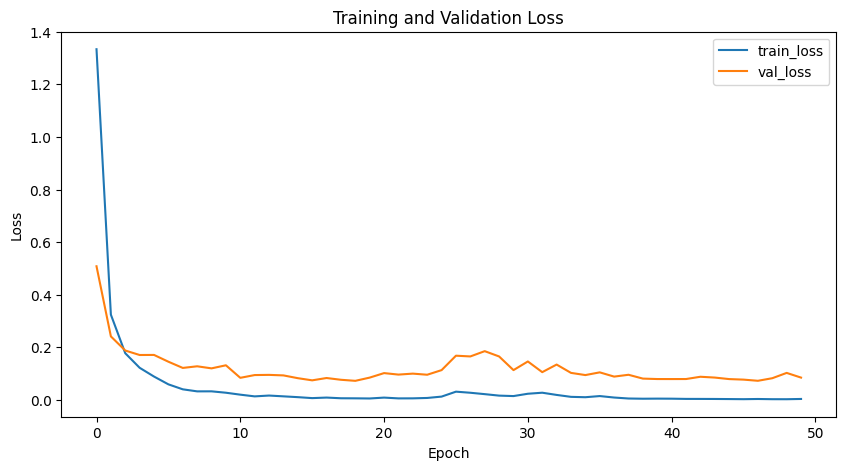

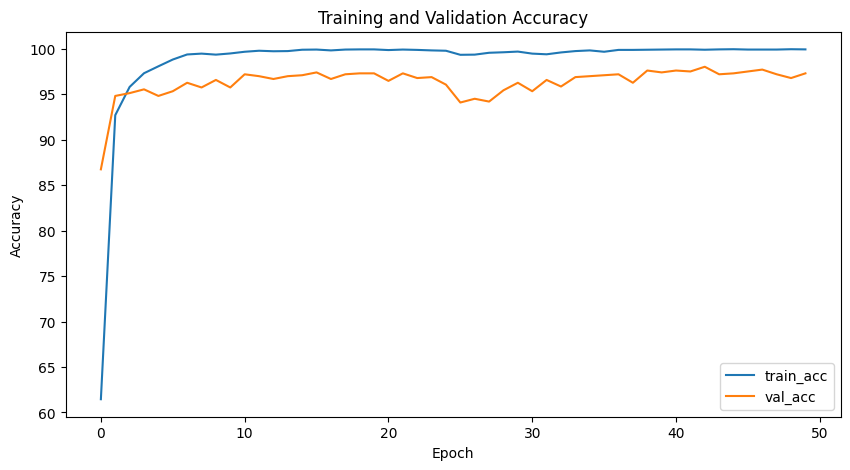

In [23]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
    # 绘制训练和验证损失
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_list, label='train_loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 绘制训练和验证准确率
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_list, label='train_acc')
    plt.plot(val_acc_list, label='val_acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_loss_and_acc(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report
def test_final(model, test_dataloader,loss_weight = 0.007):
    # 将模型设置为测试模式.
    model.eval()

       # 定义损失函数和优化器.
    criterion1 = nn.CrossEntropyLoss()
    #criterion2 = CenterLoss(6, 6).to(device)

    loss_weight=0.007
    # 在测试集上测试模型.
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []

    num_classes = 6

    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)  # 创建混淆矩阵

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 前向传播.
            outputs = model(inputs)
            pre_lab = torch.argmax(outputs, 1)
            # 计算损失和准确率.
            #loss = criterion1(outputs, labels)
            loss = criterion1(outputs, labels)# + loss_weight * criterion2(labels, outputs)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # 累计测试损失.
            test_loss += loss.item()
            y_true.extend(labels.tolist())
            y_pred.extend(pre_lab.tolist())

            # 更新混淆矩阵
            conf_matrix += confusion_matrix(labels.cpu(), pre_lab.cpu(), labels=range(num_classes))

    report = classification_report(y_true, y_pred, digits=4)
    # 计算测试准确率和损失.
    test_acc = 100.0 * test_correct / test_total
    test_loss = test_loss / len(test_dataloader)

    g_mean = np.sqrt(np.diag(conf_matrix) / np.sum(conf_matrix, axis=1))
    g_mean = np.mean(g_mean)

    # 更新分类报告
    report += '\nG-mean: {:.4f}'.format(g_mean)

    # 打印测试结果.
    # print('Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(test_loss, test_acc))
    print('Test Loss: {:.4f}, Test Acc: {:.2f}%, G-mean: {:.4f}'.format(test_loss, test_acc, g_mean))
    print(report)
    # 返回测试结果.
    return test_loss, test_acc, g_mean

In [25]:
test_loss, test_acc, g_mean=test_final(model, test_dataloader,loss_weight = 0)

Test Loss: 0.5018, Test Acc: 87.71%, G-mean: 0.9703
              precision    recall  f1-score   support

           0     0.8835    1.0000    0.9381        91
           1     0.8316    0.7596    0.7940       104
           2     0.7979    0.8824    0.8380        85
           3     1.0000    0.8306    0.9075       124
           4     0.9890    0.9474    0.9677        95
           5     0.8866    0.9053    0.8958        95
           6     0.7953    0.9902    0.8821       102
           7     0.8947    0.9273    0.9107        55
           8     0.7547    0.8333    0.7921        48
           9     0.8506    0.7872    0.8177        94
          10     0.9720    0.8125    0.8851       128
          11     0.7500    0.9310    0.8308        29

    accuracy                         0.8771      1050
   macro avg     0.8672    0.8839    0.8716      1050
weighted avg     0.8853    0.8771    0.8772      1050

G-mean: 0.9703


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import PercentFormatter

class DrawConfusionMatrix:
    def __init__(self, labels_name, normalize=True):
        self.normalize = normalize
        self.labels_name = labels_name
        self.num_classes = len(labels_name)
        self.matrix = np.zeros((self.num_classes, self.num_classes), dtype="float32")
        self.class_counts_matrix = np.zeros((self.num_classes, self.num_classes), dtype="int32")

    def update(self, labels, predicts):
        for predict, label in zip(labels, predicts):
            self.matrix[label, predict] += 1
            self.class_counts_matrix[label, predict] += 1

    def getMatrix(self, normalize=True):
        if normalize:
            per_sum = self.matrix.sum(axis=1)  # 计算每行的和，用于百分比计算
            for i in range(self.num_classes):
                self.matrix[i] = (self.matrix[i] / per_sum[i])  # 百分比转换
            self.matrix = np.around(self.matrix, 4)  # 保留4位小数点
            self.matrix[np.isnan(self.matrix)] = 0.0  # 可能存在NaN，将其设为0
        return self.matrix

    def drawMatrix(self):
        self.matrix = self.getMatrix(self.normalize)
        font = FontProperties(family='serif', style='normal', weight='normal', size=10)
        plt.figure(dpi=480)
        plt.imshow(self.matrix, cmap=plt.cm.Blues)  # 仅画出颜色格子，没有值
        plt.title("PAMAP2", fontproperties=font)  # 标题
        plt.xlabel("Predict label", fontproperties=font)
        plt.ylabel("Truth label", fontproperties=font)

        plt.yticks(range(self.num_classes), self.labels_name, fontproperties=font)  # y轴标签
        plt.xticks(range(self.num_classes), self.labels_name, rotation=0, fontproperties=font)  # x轴标签
        thresh = self.matrix.max() / 2.

        for x in range(self.num_classes):
            for y in range(self.num_classes):
                count = self.class_counts_matrix[y, x]
                #value = str(format('%.2f' % float(self.matrix[y, x] * 100.00))) + '%'  # 数值处理
                #text = f"{count}\n{value}"
                text = count
                plt.text(x, y, text, verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if self.matrix[y, x] > thresh else "black", fontproperties=font, fontsize=6)  # 写值
#                 plt.text(x, y+0.13, value, verticalalignment='center',
#                          horizontalalignment='center',
#                          color="white" if self.matrix[y, x] > thresh else "black", fontproperties=font, fontsize=8)  # 写值

        plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域

        #色条
        plt.clim(0, 1.0)
        plt.colorbar(format=PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
        plt.savefig('./ConfusionMatrix.png', bbox_inches='tight')  # bbox_inches='tight'可确保标签信息显示全
        plt.show()


def printMatrix(test_loader, model):
#     labels_name = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
#     labels_name=["Walking", "Upstairs", "Downstairs", "Sitting", "Standing", "Laying"]
    labels_name=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

    drawconfusionmatrix = DrawConfusionMatrix(labels_name=labels_name)  # 实例化
    for index, (imgs, labels) in enumerate(test_loader, 1):
        labels_pd = model(imgs.float())
        predict_np = np.argmax(labels_pd.cpu().detach().numpy(), axis=-1)  # array([0,5,1,6,3,...],dtype=int64)
        labels_np = labels.numpy()  # array([0,5,0,6,2,...],dtype=int64)
        drawconfusionmatrix.update(labels_np, predict_np)  # 将新批次的predict和label更新（保存）

    drawconfusionmatrix.drawMatrix()  # 根据所有predict和label，画出混淆矩阵

    confusion_mat = drawconfusionmatrix.getMatrix()  # 你也可以使用该函数获取混淆矩阵(ndarray)
    print(confusion_mat)

print("开始绘制混淆矩阵")
printMatrix(test_dataloader, model)

开始绘制混淆矩阵


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_bmm)